
---

# Bio3d-vision example: _platelet-em_

---

Part of the bio3d-vision project: [bio3d-vision.github.io](bio3d-vision.github.io)

Authors: Matthew Guay (matthew.guay@nih.gov), Zeyad Emam (zeyad.emam@nih.gov)

Last updated: September 10, 2019

In [2]:
import os
import numpy as np

import bio3d_vision as b3d

from bio3d_vision.windowing import gen_conjugate_corners, \
    gen_corner_points, window_generator
from bio3d_vision.util import imshow


The [bio3d-vision](https://bio3d-vision.github.io) dataset collection's goal is to aggregate high-quality, large-scale 3D biological microscopy datasets whose analyses present challenging computer vision problems of great importance to advancing the state of microscopy. 

The `bio3d_vision` package can be used to simplify the integration of bio3d-vision datasets into image processing and machine learning pipelines in Python. This notebook demonstrates how to use `bio3d_vision` to download the [platelet-em](https://bio3d-vision.github.io/platelet-description.html) dataset, load data into numpy, augment it, and window it to create collections of smaller regions for use with neural networks.

---

## Download and Extract Data


Download the [platelet-em](https://bio3d-vision.github.io/platelet-description.html) dataset to a specified `download_dir`, if the dataset doesn't already exist there.

#### Download directory

Change this to specify the directory where the dataset will be downloaded. The downloading script will create a new `platelet-em` directory within it if one does not exist.

In [3]:
# Change this to change download directory
download_dir = '.'

Use `b3d.download_if_needed` to download a named dataset if doesn't already exist in a specified download directory.

The `convert_labels_to_indexed` arg can be used to convert RGB-encoded semantic and instance label files to indexed encoding, a format that is more useful for numerical work in scripts but hampers visualization with GUI tools. **TODO**: Speed up the conversion function.

In [4]:
b3d.download_if_needed(
    'platelet-em', 
    download_dir=download_dir,
    convert_labels_to_indexed=True)

0it [00:00, ?it/s]

No platelet-em dataset found, downloading...


100%|█████████▉| 95584256/95753458 [00:45<00:00, 2762400.14it/s]

Extracting /home/matt/Desktop/platelet-em/platelet-em.zip to /home/matt/Desktop/platelet-em
Converting dataset label file TIFs from RGB to indexed.


95756288it [01:00, 2762400.14it/s]                              

Converted /home/matt/Desktop/platelet-em/labels-semantic/50-semantic.tif.
Converted /home/matt/Desktop/platelet-em/labels-semantic/24-semantic.tif.
Converted /home/matt/Desktop/platelet-em/labels-instance/24-instance-cell.tif.
Converted /home/matt/Desktop/platelet-em/labels-instance/24-instance-organelle.tif.
Converted /home/matt/Desktop/platelet-em/labels-instance/50-instance-cell.tif.
Converted /home/matt/Desktop/platelet-em/labels-instance/50-instance-organelle.tif.


---

## Load Data

Load the 50x800x800 image, semantic label, and cell instance label datasets. Note that `platelet-em` also includes an organelle instance label dataset as well.

### File paths

In [5]:
dataset_dir = os.path.join(download_dir, 'platelet-em')

# Raw image file info
raw_data_dir = os.path.join(dataset_dir, 'images')
raw_data_file = '50-images.tif'

# Semantic label file info
semantic_label_dir = os.path.join(dataset_dir, 'labels-semantic')
semantic_label_file = '50-semantic.tif'

# Instance label file info
instance_label_dir = os.path.join(dataset_dir, 'labels-instance')
instance_label_file = '50-instance-cell.tif'

### Load into numpy

In [6]:
raw_image = b3d.load(raw_data_dir, raw_data_file)
# Specify data type when loading label data
semantic_label = b3d.load(semantic_label_dir, semantic_label_file, data_type=np.int32)
instance_label = b3d.load(instance_label_dir, instance_label_file, data_type=np.int32)

for l in [raw_image, semantic_label, instance_label]:
    print(l.shape, l.min(), l.max())

(50, 800, 800) 0.0 65535.0
(50, 800, 800) 0 6
(50, 800, 800) 0 32


### Visualize

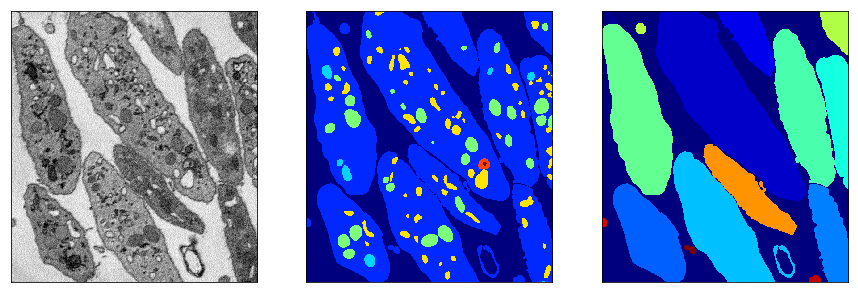

In [29]:
# Show sample image (first image in each stack)
images = (raw_image[0], semantic_label[0], instance_label[-1])

settings = (
    {'cmap': 'gray'}, 
    {'cmap': 'jet', 'vmin': 0, 'vmax': semantic_label.max()},
    {'cmap': 'jet'})

imshow(images, (15, 5), settings)

---

## Data Augmentation: Elastic Deformation

We provide code for elastic deformation. The user will likely want to add other common data augmentation and data normalization techniques. 

In [21]:
# Set deformation settings
deformation_settings = dict()
# Deformation spatial scale. Larger value = higher-frequency deformations
deformation_settings['scale'] = 40
# Deformation amplitude mean. Larger value = more noticeable deformations.
# This value is jacked up to make the difference demonstrable. In
# practice you might want something more like 20
deformation_settings['alpha'] = 40
# Deformation amplitude standard deviation. Larger value = more variance in
# deformation strength across the image.
deformation_settings['sigma'] = 0.6

# Choose deformation random seed (this is important to make sure both image 
# and label data are deformed the same)
deformation_random_seed = 1

# Perform elastic deformation
deformed_raw_image = b3d.deform(
    raw_image,
    deformation_settings,
    random_seed=deformation_random_seed)

deformed_semantic_label = b3d.deform(
    semantic_label,
    deformation_settings,
    random_seed=deformation_random_seed)

deformed_instance_label = b3d.deform(
    instance_label,
    deformation_settings,
    random_seed=deformation_random_seed)

### Visualize

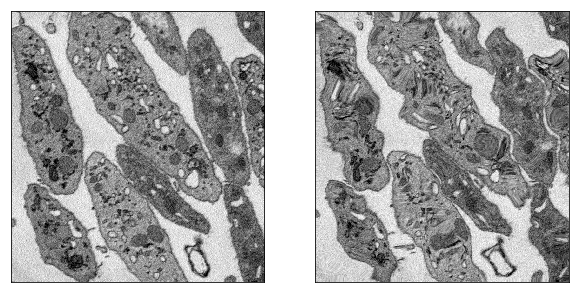

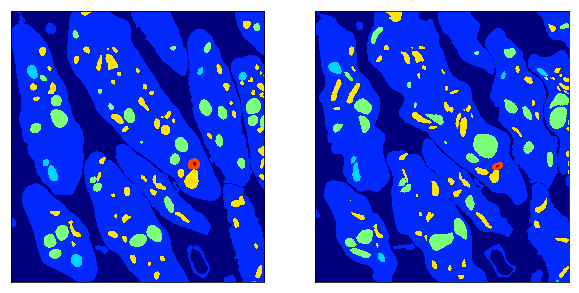

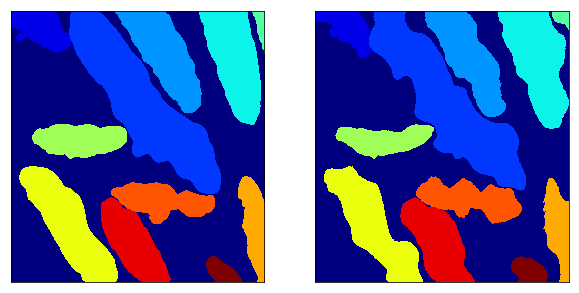

In [22]:
# Show effect of deformations
images1 = (raw_image[0], deformed_raw_image[0])
settings1 = [{'cmap': 'gray'}] * 2

images2 = (semantic_label[0], deformed_semantic_label[0])
settings2 = [{'cmap': 'jet', 'vmin': 0, 'vmax': semantic_label.max()}] * 2

images3 = (instance_label[0], deformed_instance_label[0])
settings3 = [{'cmap': 'jet'}] * 2

for i, s in zip([images1, images2, images3], [settings1, settings2, settings3]):
    imshow(i, (10, 5), s)

---

## Windowing

We supply functions for random windowing as well as generating two windows of different shape centered at the same location (in case input and output of neural networks are different shapes). 

### Compute window corners

To generate corresponding windows from several data and label volumes, define the windows first by their corner location.

In [23]:
# Fix the windowing parameters
random_windowing = True
corner_generation_seed = 1
image_window_shape = [5, 200, 400] # corresponds to the shape input to the neural network (larger than output)
label_window_shape = [5, 100, 200] # corresponds to the shape output by the neural network (smaller than input)
window_spacing = [5, 50, 100] # implies there will be no overlap in z but half the image will overlap in x and y.
corner_generation_random_seed = 1989

# Generate a list of corner points for the labels
label_corner_points = gen_corner_points(spatial_shape=deformed_semantic_label.shape,
                                  window_spacing=window_spacing,
                                  window_shape=label_window_shape,
                                  random_windowing=random_windowing,
                                  random_seed=corner_generation_random_seed)

# Generate a list of corner poins for the images
image_corner_points = gen_conjugate_corners(corner_points=label_corner_points,
                                          window_shape=label_window_shape,
                                          conjugate_window_shape=image_window_shape)

### Create window generators

Rather than instantiating all windows at once, create a generator from each data source that produces window arrays on demand.

In [24]:
image_window_generator = window_generator(
    deformed_raw_image,
    window_shape=image_window_shape,
    corner_points=image_corner_points)

semantic_label_window_generator = window_generator(
    deformed_semantic_label,
    window_shape=label_window_shape,
    corner_points=label_corner_points)

instance_label_window_generator = window_generator(
    deformed_instance_label,
    window_shape=label_window_shape,
    corner_points=label_corner_points)

### Visualization: Example 1

Show sample windows (first image in each stack). Notice the mirroring on the left in the raw image window.

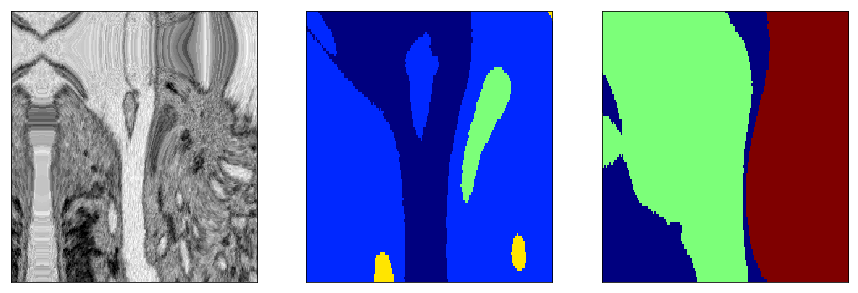

In [25]:
# Show sample windows (first image in each stack)
# Notice the mirroring on the left in the raw window!
images = (
    next(image_window_generator)[0],
    next(semantic_label_window_generator)[0],
    next(instance_label_window_generator)[0])

settings = (
    {'cmap': 'gray'},
    {'cmap': 'jet', 'vmin': 0, 'vmax': semantic_label.max()},
    {'cmap': 'jet'})

imshow(images, (15, 5), settings)

### Visualization: Example 2

Some more window triplet examples

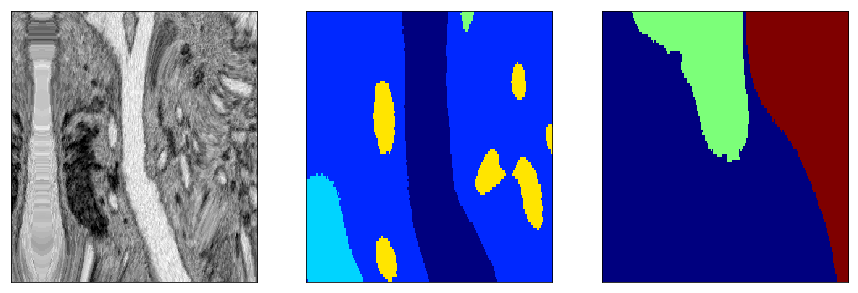

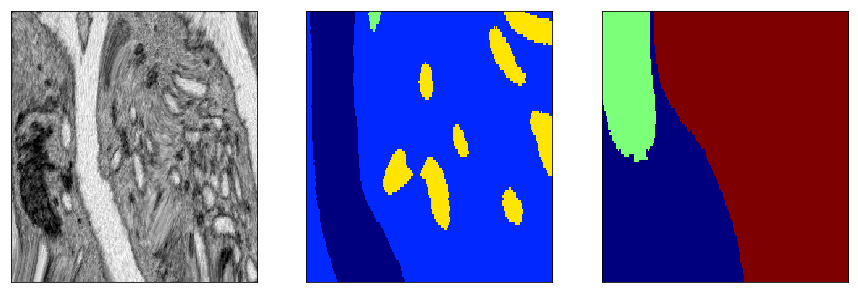

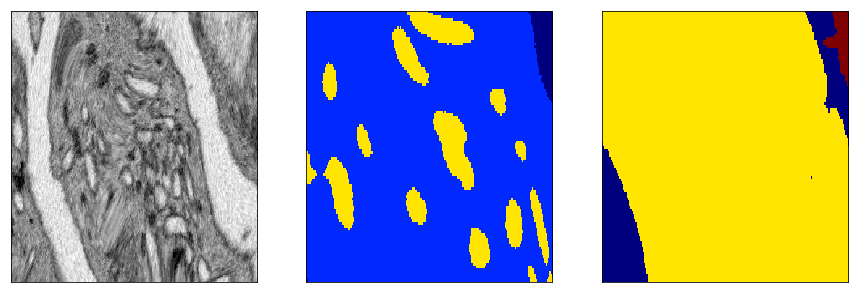

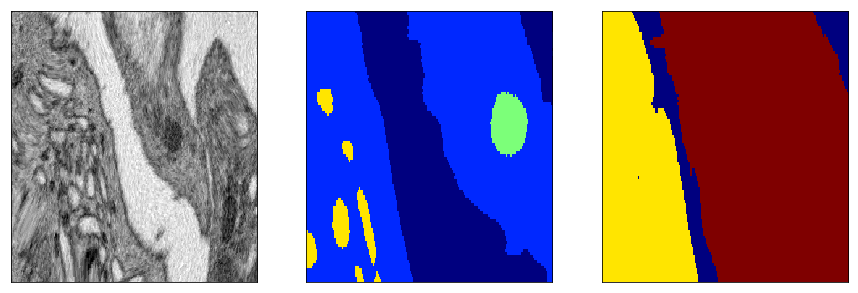

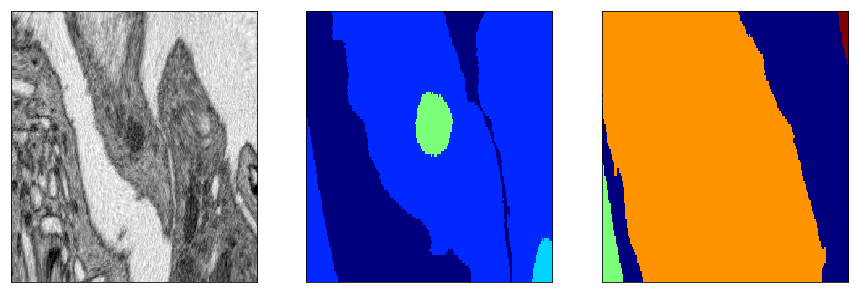

In [28]:

settings = (
    {'cmap': 'gray'},
    {'cmap': 'jet', 'vmin': 0, 'vmax': semantic_label.max()},
    {'cmap': 'jet'})

for _ in range(5):
    images = (
        next(image_window_generator)[0],
        next(semantic_label_window_generator)[0],
        next(instance_label_window_generator)[0])

    imshow(images, (15, 5), settings)